## Notebook for assigning electrolyte score

### Database: eMolecules

**Created on 14th November, 2022; remodified on 11th February, 2024**

In [59]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, Draw
import numpy as np
from sklearn import preprocessing
import textwrap
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/escore-calcs/emolecules
total 64320
-rw-------@ 1 riteshk  staff  7832608 Feb  8 11:18 preds_oxstab_emolecules_screened.csv
-rw-------@ 1 riteshk  staff  7975446 Feb 11 00:55 preds_cond_emolecules_screened_021124.csv
-rw-------@ 1 riteshk  staff  7616102 Feb 11 13:34 preds_oxstab_emolecules_screened_021124.csv
-rw-------@ 1 riteshk  staff  6305493 Feb 11 19:59 preds_ce_emol_screened_021124.csv
-rw-------@ 1 riteshk  staff    12208 Feb 11 21:02 all_multi_comp_ce.csv
-rw-------@ 1 riteshk  staff   728011 Feb 11 21:02 all_multi_comp_cond.csv
-rw-------@ 1 riteshk  staff   917505 Feb 11 21:02 all_oxstab.csv
-rw-------@ 1 riteshk  staff   765127 Feb 11 21:07 all_multi_comp_cond_comm.csv
-rw-r--r--  1 riteshk  staff   421734 Feb 11 21:32 emol_high_overall_score_wt1_1M.csv
-rw-r--r--  1 riteshk  staff   332653 Feb 11 23:23 emol_high_overall_score_wt2_1M.csv
-rw-r--r--  1 riteshk  staff   332447 Fe

In [3]:
df_emol = pd.read_csv('preds_cond_emolecules_screened_021124.csv')
df_emol

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var
0,CC(=O)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.496380,0.061641
1,CC(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.323279,0.041828
2,O=C1CCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.138788,0.004402
3,CCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869589,0.005092
4,O=CC1CO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.713039,0.014474
...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.068743,0.022824
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.917413,0.089262
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.194676,0.028547
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.232416,0.037728


In [4]:
df_emol_ce = pd.read_csv('preds_ce_emol_screened_021124_2M.csv')
df_emol_ce

,solv_comb_sm,salt_sm,log(1-CE)
0,CC(=O)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.118226
1,CC(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.580814
2,O=C1CCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.455501
3,CCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.945726
4,O=CC1CO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.049181
...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.131892
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.424597
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.115217
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.810474


In [56]:
df_emol_ce.sort_values(by='log(1-CE)', ascending=True)

,solv_comb_sm,salt_sm,log(1-CE)
1828,B12B3B4B5B(B14)[Si]235,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-8.358293
81,B12B3B4B1C234,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-7.374405
7323,N12[Si]34N5[Si]11N3[Si]25N41,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-6.297741
4691,O=C1C(=O)C(=O)C(=O)C(=O)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-3.456071
3400,CC[SiH](Cl)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.798223
...,...,...,...
52009,CN1CCOCCOCCN(C)C(=O)N2CCOCCOCCN(CCOCC2)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.426252
33906,C(CN1CCOCCOCCOCCOCC1)N1CCOCCOCCOCCOCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.382250
37168,C(CN1CCOCCOCCOCCOCC1)CN1CCOCCOCCOCCOCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.377336
27283,CN(C)B(B(N(C)C)N(C)C)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.375813


In [5]:
df_emol_os = pd.read_csv('preds_oxstab_emolecules_screened_021124.csv')
df_emol_os

,solv_comb_sm,salt_sm,IE,IE_ensemble_uncal_var
0,CC(=O)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,7.488391,0.027438
1,CC(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,6.355432,0.041991
2,O=C1CCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,6.973953,0.014051
3,CCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,5.978584,0.007700
4,O=CC1CO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,6.796157,0.022245
...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,3.913700,0.068856
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,5.937648,0.021264
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,3.916934,0.076843
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,4.147219,0.035536


In [6]:
## reading original datasets
df_cond = pd.read_csv('all_multi_comp_cond_comm.csv')
df_cond['conductivity'] = np.power(10, df_cond['conductivity_log'])
cond = df_cond['conductivity']
df_os = pd.read_csv('all_oxstab.csv')
oxstab = df_os['IE']
df_ce = pd.read_csv('all_multi_comp_ce.csv')
ce = df_ce['coulombic_efficiency']
df_ce

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,protocol,current_density,coulombic_efficiency
0,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,NaN,0,2.0,0.80000
1,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,O=S=O,1,5.0,0.83600
2,C1CCOC1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,5.0,0.89400
3,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
4,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
...,...,...,...,...,...,...,...,...,...
137,CO[Si](C)(C)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.99759
138,O=S1(=O)CCCC1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98200
139,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98800
140,COC1OCC(C(F)(F)F)O1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,1.0,0.98700


In [7]:
## Extremum values of all original datasets
print(max(cond), min(cond))
print(max(oxstab), min(oxstab))
print(max(ce), min(ce))

66.79000001752941 1.790000001979125e-07
11.03454344 0.027343104
0.9994000000001512 0.0899999995711704


In [8]:
df_emol['conductivity'] = np.power(10, df_emol['conductivity_log'])
df_emol['coulombic_efficiency'] = 1 - np.power(10, df_emol_ce['log(1-CE)'])
df_emol['oxstab'] = df_emol_os['IE']
df_emol

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var,conductivity,coulombic_efficiency,oxstab
0,CC(=O)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.496380,0.061641,3.136031,0.992383,7.488391
1,CC(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.323279,0.041828,2.105130,0.997375,6.355432
2,O=C1CCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.138788,0.004402,13.765388,0.964965,6.973953
3,CCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869589,0.005092,7.406098,0.988669,5.978584
4,O=CC1CO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.713039,0.014474,5.164625,0.991071,6.796157
...,...,...,...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.068743,0.022824,0.853606,0.926191,3.913700
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.917413,0.089262,0.120945,0.962381,5.937648
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.194676,0.028547,0.638740,0.923302,3.916934
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.232416,0.037728,1.707718,0.984529,4.147219


In [9]:
emol_cond = df_emol['conductivity']
emol_os = df_emol['oxstab']
emol_ce = df_emol['coulombic_efficiency']

In [10]:
## Extreme values of all predicted properties for emolecules dataset
print(max(emol_cond), min(emol_cond))
print(max(emol_os), min(emol_os))
print(max(emol_ce), min(emol_ce))

20.587940173630717 0.0008362898341019088
8.790046848261573 2.6710439932569585
0.9999999967894386 0.3782630299241635


**Step 1: Normalization**

In [11]:
## Define a scaler for conductivity
cond_div = np.linspace(max(cond), min(cond),1000000) ## dividing the range into 1 million points
cond_div = cond_div.reshape(-1, 1)
scaler_cond = preprocessing.MinMaxScaler() ## Using MinMax Scaler
scaler_cond.fit(cond_div)
cond_sc = scaler_cond.transform(cond_div)
cond_sc

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [12]:
## Standardize the original conductivity values
emol_cond = np.array(emol_cond).reshape(-1,1)
emol_cond_sc = scaler_cond.transform(emol_cond)
print(emol_cond_sc)
print(max(emol_cond_sc), min(emol_cond_sc))

[[0.0469536 ]
 [0.03151864]
 [0.20609953]
 ...
 [0.00956341]
 [0.02556846]
 [0.0101952 ]]
[0.30824884] [1.25185033e-05]


In [13]:
## Define a scaler for oxidative stability
os_div = np.linspace(max(oxstab), min(oxstab),1000000).reshape(-1, 1)
scaler_os = preprocessing.MinMaxScaler()
scaler_os.fit(os_div)
scaler_os.transform(os_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [14]:
## Standardize the original oxidative stability values
emol_os = np.array(emol_os).reshape(-1,1)
emol_os_sc = scaler_os.transform(emol_os)
print(emol_os_sc)
print(max(emol_os_sc), min(emol_os_sc))

[[0.67783342]
 [0.57490446]
 [0.63109692]
 ...
 [0.35336789]
 [0.37428914]
 [0.47554579]]
[0.79608833] [0.24017923]


In [15]:
## Define a scaler for coulombic efficiency
ce_div = np.linspace(max(ce), min(ce),1000000).reshape(-1, 1)
scaler_ce = preprocessing.MinMaxScaler()
scaler_ce.fit(ce_div)
scaler_ce.transform(ce_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [16]:
## Standardize the original coulombic efficiency values
emol_ce = np.array(emol_ce).reshape(-1,1)
emol_ce_sc = scaler_ce.transform(emol_ce)
print(emol_ce_sc)
print(max(emol_ce_sc), min(emol_ce_sc))

[[0.99228412]
 [0.99777288]
 [0.96213462]
 ...
 [0.91632078]
 [0.98364717]
 [0.97441849]]
[1.00065977] [0.31698156]


In [17]:
## Combine the standardized values into a dataframe
target_df = pd.DataFrame()
target_df['solv_comb_sm'] = df_emol['solv_comb_sm']
target_df['conductivity'] = df_emol['conductivity']
target_df['oxstab'] = df_emol['oxstab']
target_df['coulombic_efficiency'] = df_emol['coulombic_efficiency']
# target_df['similarity'] = emol_max_sim
target_df

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency
0,CC(=O)C#N,3.136031,7.488391,0.992383
1,CC(=O)C=O,2.105130,6.355432,0.997375
2,O=C1CCO1,13.765388,6.973953,0.964965
3,CCCC=O,7.406098,5.978584,0.988669
4,O=CC1CO1,5.164625,6.796157,0.991071
...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,0.853606,3.913700,0.926191
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,0.120945,5.937648,0.962381
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,0.638740,3.916934,0.923302
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,1.707718,4.147219,0.984529


In [18]:
target_df['cond_std'] = emol_cond_sc
target_df['oxstab_std'] = emol_os_sc
target_df['CE_std'] = emol_ce_sc

In [19]:
target_df.loc[target_df['solv_comb_sm'] == 'CCN1CCOCC1'] ## EM

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
853,CCN1CCOCC1,7.207945,3.867303,0.972619,0.10792,0.348859,0.970551


In [20]:
target_df.loc[target_df['solv_comb_sm'] == 'COC(=O)C#N'] ## MCF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
74,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211


In [21]:
target_df.loc[target_df['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
2651,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497


In [22]:
target_df.loc[target_df['solv_comb_sm'] == 'CCOCCS(F)(=O)=O'] ## EESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
7456,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276


In [23]:
# target_df[['conductivity','cond_std']]

,conductivity,cond_std
0,3.136031,0.046954
1,2.105130,0.031519
2,13.765388,0.206100
3,7.406098,0.110886
4,5.164625,0.077326
...,...,...
76599,0.853606,0.012780
76600,0.120945,0.001811
76601,0.638740,0.009563
76602,1.707718,0.025568


1. Equal weights for $\sigma$, CE, & IE

In [24]:
cond_score_1 = []
os_score_1 = []
ce_score_1 = []
cond_wt = 0.33
os_wt = 0.33
ce_wt = 0.33
for i in range(len(df_emol)):
    if df_emol['conductivity'][i] >= 1.0 and df_emol['oxstab'][i] >= 4.5 and df_emol['coulombic_efficiency'][i] >= 0.985:
        cond_score_1.append(cond_wt * target_df['cond_std'][i])
        os_score_1.append(os_wt * target_df['oxstab_std'][i])
        ce_score_1.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_1.append(0.0)
        os_score_1.append(0.0)
        ce_score_1.append(0.0)

In [25]:
overall_score_1 = [(cond_score_1[i]+os_score_1[i]+ce_score_1[i]) for i in range(len(df_emol))]

In [26]:
target_df['overall_score_1'] = overall_score_1
high_score_df_1 = target_df.loc[target_df['overall_score_1'] > 0.0]
high_score_df_1_ = high_score_df_1.sort_values(by=['overall_score_1'], ascending=False)
high_score_df_1_.reset_index(drop=True, inplace=True)
high_score_df_1_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1
0,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642
1,CC(C#N)C#N,15.532408,7.805156,0.991894,0.232556,0.706611,0.991747,0.637202
2,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211,0.632583
3,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385
4,CC(=O)OC(C#N)C#N,14.454636,7.667094,0.985106,0.216419,0.694068,0.984282,0.625274
...,...,...,...,...,...,...,...,...
4631,O=C1CCCN2CCCC12,1.350145,4.579180,0.985327,0.020215,0.413533,0.984525,0.468030
4632,CCOC1CSC2(CN(C2)C(=O)C(C)C)C1,1.650576,4.517540,0.985176,0.024713,0.407933,0.984359,0.467612
4633,CCOP(OCC)O[Si](C)(C)C,1.243390,4.558343,0.986505,0.018616,0.411640,0.985821,0.467305
4634,CC(C)C(=O)N1CCCN(CC1)C(=O)C(C)C,1.253393,4.572007,0.985199,0.018766,0.412881,0.984384,0.467290


In [27]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_1_, smilesCol='solv_comb_sm')
high_score_df_1_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol
0,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642,<rdkit.Chem.rdchem.Mol object at 0x17fdb4cf0>
1,CC(C#N)C#N,15.532408,7.805156,0.991894,0.232556,0.706611,0.991747,0.637202,<rdkit.Chem.rdchem.Mol object at 0x17fe0de40>
2,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211,0.632583,<rdkit.Chem.rdchem.Mol object at 0x17fe0ddd0>
3,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385,<rdkit.Chem.rdchem.Mol object at 0x17fe0d6d0>
4,CC(=O)OC(C#N)C#N,14.454636,7.667094,0.985106,0.216419,0.694068,0.984282,0.625274,<rdkit.Chem.rdchem.Mol object at 0x17fe0d120>


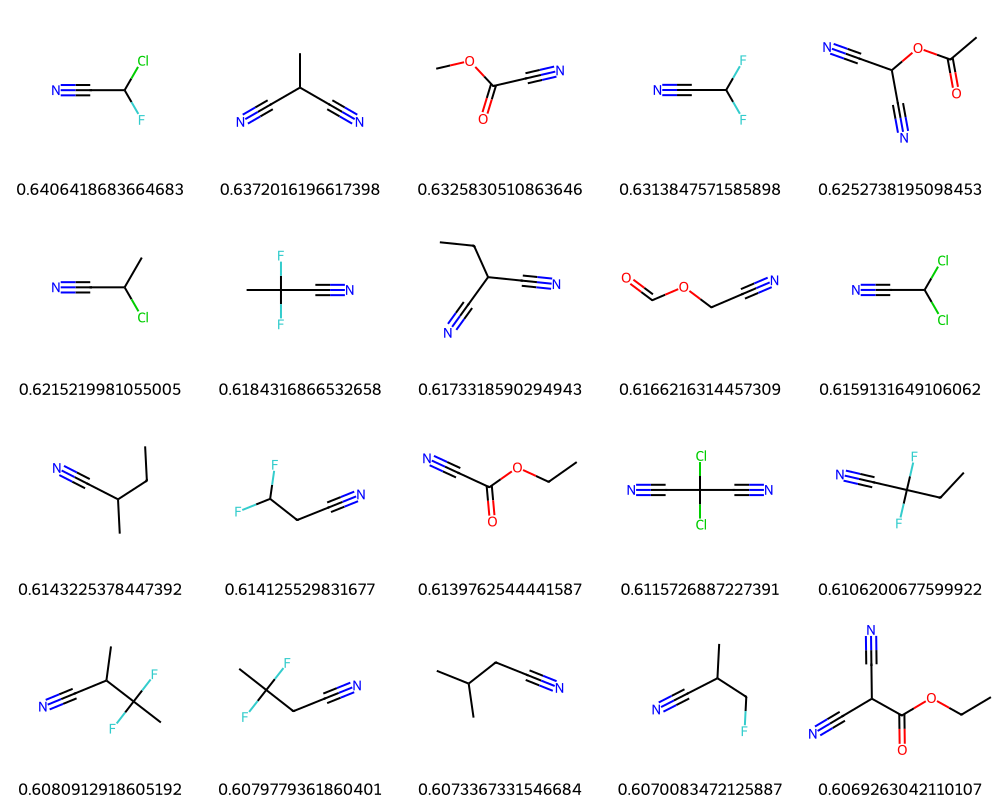

In [28]:
PandasTools.FrameToGridImage(high_score_df_1_.iloc[:20,:], legendsCol="overall_score_1", molsPerRow=5)

In [29]:
# high_score_df_1_.drop(labels=['ROMol'], axis=1, inplace=True)
# high_score_df_1_.reset_index(drop=True, inplace=True)
high_score_df_1_.to_csv('emol_high_overall_score_wt1.csv', index=False)

2. Very low weights for $\sigma$ & CE; very high weight for IE

In [30]:
cond_score_2 = []
os_score_2 = []
ce_score_2 = []
cond_wt = 0.05
os_wt = 0.9
ce_wt = 0.05
for i in range(len(df_emol)):
    if df_emol['conductivity'][i] >= 1.0 and df_emol['oxstab'][i] >= 4.5 and df_emol['coulombic_efficiency'][i] >= 0.985:
        cond_score_2.append(cond_wt * target_df['cond_std'][i])
        os_score_2.append(os_wt * target_df['oxstab_std'][i])
        ce_score_2.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_2.append(0.0)
        os_score_2.append(0.0)
        ce_score_2.append(0.0)

In [31]:
overall_score_2 = [(cond_score_2[i]+os_score_2[i]+ce_score_2[i]) for i in range(len(df_emol))]

In [32]:
target_df['overall_score_2'] = overall_score_2
high_score_df_2 = target_df.loc[target_df['overall_score_2'] > 0.0]
high_score_df_2_ = high_score_df_2.sort_values(by=['overall_score_2'], ascending=False)
high_score_df_2_.reset_index(drop=True, inplace=True)
high_score_df_2_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2
0,FC(F)(F)C(F)(F)C(F)(F)C#N,1.295404,8.751907,0.993699,0.019395,0.792623,0.993731,0.595897,0.764017
1,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385,0.758293
2,FC(F)C(F)(F)C(F)(F)C(F)(F)C#N,1.003551,8.526005,0.992840,0.015025,0.772100,0.992786,0.587371,0.745281
3,FC(C#N)C(F)(F)F,3.310925,8.488985,0.994751,0.049572,0.768737,0.994888,0.598355,0.744086
4,FC(F)(F)C(F)(F)CC#N,2.726289,8.453541,0.995242,0.040819,0.765517,0.995428,0.594582,0.740778
...,...,...,...,...,...,...,...,...,...
4631,CC(C)N1CCCC(C1)C=O,3.237200,4.505401,0.985263,0.048468,0.406830,0.984455,0.475119,0.417793
4632,CCOC1CSC2(CN(C2)C(=O)C(C)C)C1,1.650576,4.517540,0.985176,0.024713,0.407933,0.984359,0.467612,0.417593
4633,CCCN(C(C)C)S(=O)(=O)N(C)C,1.908833,4.504699,0.987473,0.028580,0.406766,0.986885,0.469336,0.416863
4634,CCSC(SCC)SCC,1.569034,4.503679,0.993348,0.023492,0.406673,0.993345,0.469759,0.416848


In [33]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_2_, smilesCol='solv_comb_sm')
high_score_df_2_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,ROMol
0,FC(F)(F)C(F)(F)C(F)(F)C#N,1.295404,8.751907,0.993699,0.019395,0.792623,0.993731,0.595897,0.764017,<rdkit.Chem.rdchem.Mol object at 0x17febedd0>
1,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385,0.758293,<rdkit.Chem.rdchem.Mol object at 0x17febe6d0>
2,FC(F)C(F)(F)C(F)(F)C(F)(F)C#N,1.003551,8.526005,0.992840,0.015025,0.772100,0.992786,0.587371,0.745281,<rdkit.Chem.rdchem.Mol object at 0x2891c9cf0>
3,FC(C#N)C(F)(F)F,3.310925,8.488985,0.994751,0.049572,0.768737,0.994888,0.598355,0.744086,<rdkit.Chem.rdchem.Mol object at 0x2891c9eb0>
4,FC(F)(F)C(F)(F)CC#N,2.726289,8.453541,0.995242,0.040819,0.765517,0.995428,0.594582,0.740778,<rdkit.Chem.rdchem.Mol object at 0x2891c9c80>


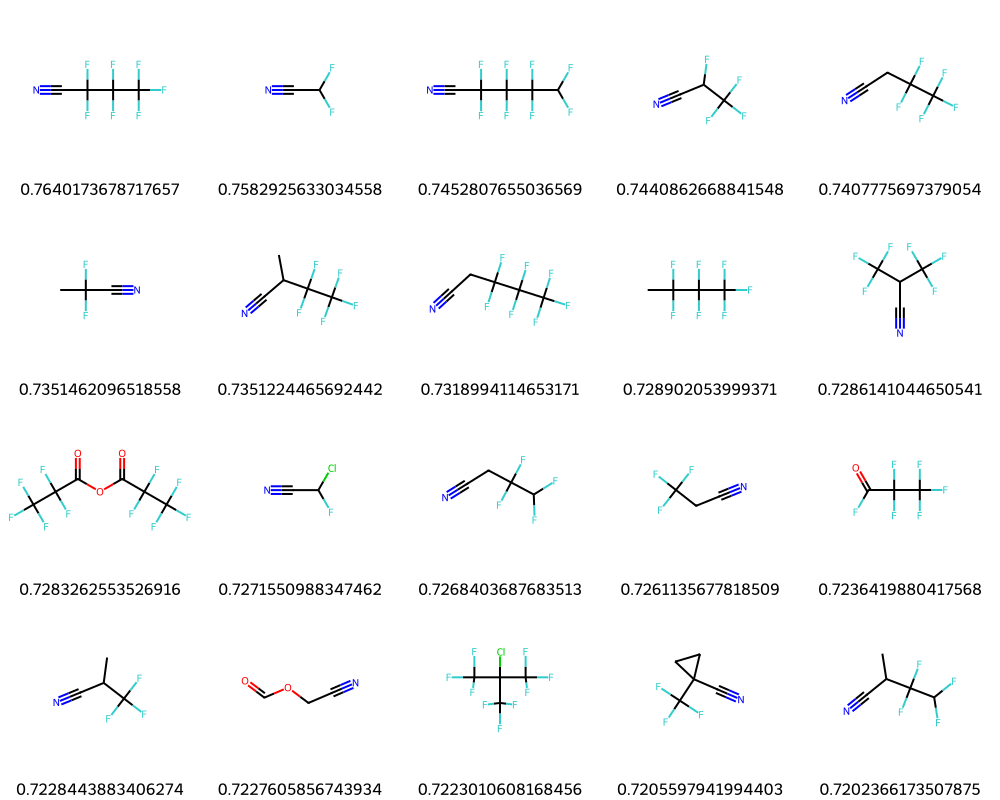

In [34]:
PandasTools.FrameToGridImage(high_score_df_2_.iloc[:20,:], legendsCol="overall_score_2", molsPerRow=5)

In [35]:
high_score_df_2_.drop(labels=['ROMol','overall_score_1'], axis=1, inplace=True)
high_score_df_2_.reset_index(drop=True, inplace=True)
high_score_df_2_.to_csv('emol_high_overall_score_wt2.csv')

3. Very low weights for $\sigma$ & IE; very high weight for CE

In [36]:
cond_score_3 = []
os_score_3 = []
ce_score_3 = []
cond_wt = 0.05
os_wt = 0.05
ce_wt = 0.9
for i in range(len(df_emol)):
    if df_emol['conductivity'][i] >= 1.0 and df_emol['oxstab'][i] >= 4.5 and df_emol['coulombic_efficiency'][i] >= 0.985:
        cond_score_3.append(cond_wt * target_df['cond_std'][i])
        os_score_3.append(os_wt * target_df['oxstab_std'][i])
        ce_score_3.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_3.append(0.0)
        os_score_3.append(0.0)
        ce_score_3.append(0.0)

In [37]:
overall_score_3 = [(cond_score_3[i]+os_score_3[i]+ce_score_3[i]) for i in range(len(df_emol))]

In [38]:
target_df['overall_score_3'] = overall_score_3
high_score_df_3 = target_df.loc[target_df['overall_score_3'] > 0.0]
high_score_df_3_ = high_score_df_3.sort_values(by=['overall_score_3'], ascending=False)
high_score_df_3_.reset_index(drop=True, inplace=True)
high_score_df_3_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3
0,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642,0.727155,0.944393
1,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385,0.758293,0.944335
2,CC(F)(F)C#N,8.059872,8.333822,0.998236,0.120675,0.754641,0.998720,0.618432,0.735146,0.942614
3,FC(F)CC#N,8.762736,8.083794,0.997456,0.131198,0.731926,0.997863,0.614126,0.715186,0.941233
4,CC(C)(F)C#N,9.147530,7.707833,0.998371,0.136960,0.697770,0.998869,0.605087,0.684784,0.940719
...,...,...,...,...,...,...,...,...,...,...
4631,O=C1CCCN2CCCC12,1.350145,4.579180,0.985327,0.020215,0.413533,0.984525,0.468030,0.422416,0.907760
4632,CCOC1CSC2(CN(C2)C(=O)C(C)C)C1,1.650576,4.517540,0.985176,0.024713,0.407933,0.984359,0.467612,0.417593,0.907556
4633,CC(C)C(=O)N1CCCN(CC1)C(=O)C(C)C,1.253393,4.572007,0.985199,0.018766,0.412881,0.984384,0.467290,0.421750,0.907528
4634,CC1(C)CC(=O)CC2CCCN12,1.078461,4.632300,0.985037,0.016147,0.418359,0.984206,0.468175,0.426540,0.907510


In [39]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_3_, smilesCol='solv_comb_sm')
high_score_df_3_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,ROMol
0,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642,0.727155,0.944393,<rdkit.Chem.rdchem.Mol object at 0x28bf135f0>
1,FC(F)C#N,9.035913,8.608145,0.997978,0.135288,0.779563,0.998436,0.631385,0.758293,0.944335,<rdkit.Chem.rdchem.Mol object at 0x28bf13580>
2,CC(F)(F)C#N,8.059872,8.333822,0.998236,0.120675,0.754641,0.998720,0.618432,0.735146,0.942614,<rdkit.Chem.rdchem.Mol object at 0x28bf132e0>
3,FC(F)CC#N,8.762736,8.083794,0.997456,0.131198,0.731926,0.997863,0.614126,0.715186,0.941233,<rdkit.Chem.rdchem.Mol object at 0x28bf13660>
4,CC(C)(F)C#N,9.147530,7.707833,0.998371,0.136960,0.697770,0.998869,0.605087,0.684784,0.940719,<rdkit.Chem.rdchem.Mol object at 0x28bf133c0>


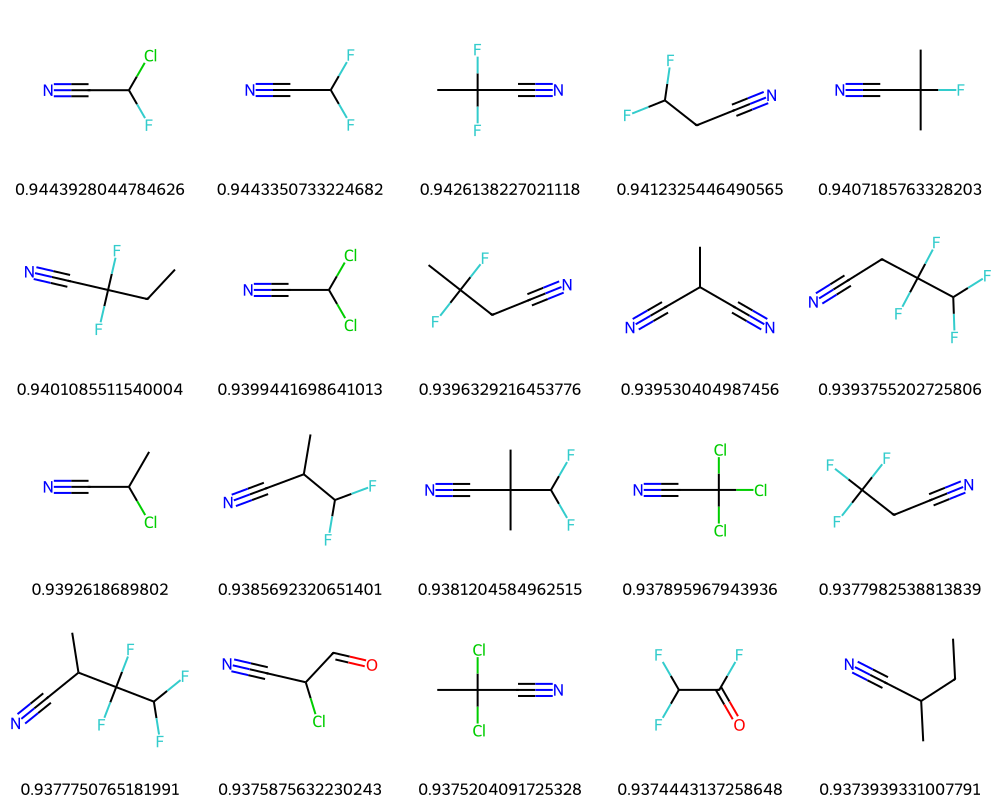

In [40]:
PandasTools.FrameToGridImage(high_score_df_3_.iloc[:20,:], legendsCol="overall_score_3", molsPerRow=5)

In [41]:
high_score_df_3_.drop(labels=['ROMol','overall_score_1','overall_score_2'], axis=1, inplace=True)
high_score_df_3_.reset_index(drop=True, inplace=True)
high_score_df_3_.to_csv('emol_high_overall_score_wt3.csv')

4. Very low weights for IE & CE; very high weight for $\sigma$

In [42]:
cond_score_4 = []
os_score_4 = []
ce_score_4 = []
cond_wt = 0.9
os_wt = 0.05
ce_wt = 0.05
for i in range(len(df_emol)):
    if df_emol['conductivity'][i] >= 1.0 and df_emol['oxstab'][i] >= 4.5 and df_emol['coulombic_efficiency'][i] >= 0.985:
        cond_score_4.append(cond_wt * target_df['cond_std'][i])
        os_score_4.append(os_wt * target_df['oxstab_std'][i])
        ce_score_4.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_4.append(0.0)
        os_score_4.append(0.0)
        ce_score_4.append(0.0)

In [43]:
overall_score_4 = [(cond_score_4[i]+os_score_4[i]+ce_score_4[i]) for i in range(len(df_emol))]

In [44]:
target_df['overall_score_4'] = overall_score_4
high_score_df_4 = target_df.loc[target_df['overall_score_4'] > 0.0]
high_score_df_4_ = high_score_df_4.sort_values(by=['overall_score_4'], ascending=False)
high_score_df_4_.reset_index(drop=True, inplace=True)
high_score_df_4_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,overall_score_4
0,CC(C#N)C#N,15.532408,7.805156,0.991894,0.232556,0.706611,0.991747,0.637202,0.697165,0.939530,0.294218
1,CN(C)CC#N,15.753705,4.749834,0.986579,0.235869,0.429037,0.985902,0.544767,0.447221,0.920557,0.283029
2,CC(=O)OC(C#N)C#N,14.454636,7.667094,0.985106,0.216419,0.694068,0.984282,0.625274,0.684697,0.931378,0.278695
3,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211,0.632583,0.707059,0.936675,0.273184
4,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642,0.727155,0.944393,0.269791
...,...,...,...,...,...,...,...,...,...,...,...
4631,CC1CSC(C)C1=O,1.058288,4.773486,0.987330,0.015845,0.431185,0.986728,0.473140,0.438195,0.910406,0.085156
4632,CN1CCCC1CC(=O)C(F)F,1.079235,4.717280,0.986168,0.016159,0.426079,0.985450,0.471137,0.433552,0.909017,0.085119
4633,CCP(=O)(CC)C[Si](C)(C)C,1.054860,4.725190,0.991144,0.015794,0.426798,0.990921,0.473059,0.434454,0.913959,0.085100
4634,FC(F)CN1CCC(=O)CC1,1.057267,4.651227,0.988775,0.015830,0.420078,0.988317,0.469994,0.428278,0.911281,0.084666


In [45]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_4_, smilesCol='solv_comb_sm')
high_score_df_4_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,overall_score_4,ROMol
0,CC(C#N)C#N,15.532408,7.805156,0.991894,0.232556,0.706611,0.991747,0.637202,0.697165,0.939530,0.294218,<rdkit.Chem.rdchem.Mol object at 0x28f703d60>
1,CN(C)CC#N,15.753705,4.749834,0.986579,0.235869,0.429037,0.985902,0.544767,0.447221,0.920557,0.283029,<rdkit.Chem.rdchem.Mol object at 0x28f703510>
2,CC(=O)OC(C#N)C#N,14.454636,7.667094,0.985106,0.216419,0.694068,0.984282,0.625274,0.684697,0.931378,0.278695,<rdkit.Chem.rdchem.Mol object at 0x28f7035f0>
3,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211,0.632583,0.707059,0.936675,0.273184,<rdkit.Chem.rdchem.Mol object at 0x28f703c10>
4,FC(Cl)C#N,13.572054,8.186762,0.996539,0.203205,0.741280,0.996854,0.640642,0.727155,0.944393,0.269791,<rdkit.Chem.rdchem.Mol object at 0x28f703900>


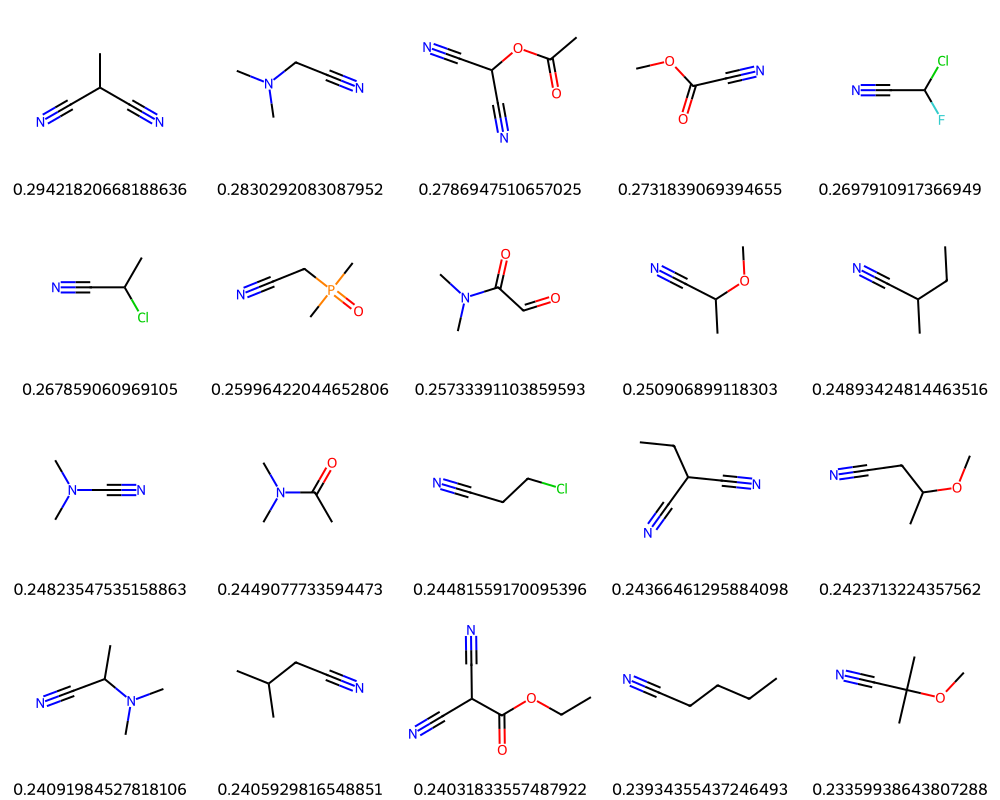

In [46]:
PandasTools.FrameToGridImage(high_score_df_4_.iloc[:20,:], legendsCol="overall_score_4", molsPerRow=5)

In [47]:
high_score_df_4_.drop(labels=['ROMol','overall_score_1','overall_score_2','overall_score_3'], axis=1, inplace=True)
high_score_df_4_.reset_index(drop=True, inplace=True)
high_score_df_4_.to_csv('emol_high_overall_score_wt4.csv')

**Generate molecular structure visualization for molecules with top predicted eScore**

In [60]:
def grid_mols_with_annotation(mols, labels, sub_img_size=250, mols_per_row=5, title="", annotation_size=20, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(sub_img_size, sub_img_size), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size/2, sub_img_size+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        # wrapped_text = textwrap.fill(cmpd_text, 30)
        wrapped_text = '\n'.join([textwrap.fill(line, 32) for line in cmpd_text.split('\n')]) ## had to change to 32 for salts, but for solvents 25 works
        plt.annotate(wrapped_text, text_pos, fontsize=25, horizontalalignment='center')
        # plt.annotate(cmpd_text, text_pos, fontsize=20, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size, text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size/2, text_pos[1] + sub_img_size)

    ax.imshow(img, origin="upper")

In [64]:
# label = ['{}\n {}\n {}'.format(df_edb_unique['smiles'][i], ', '.join(df_edb_unique['database'][i]), df_edb_unique['class'][i]) for i in range(len(df_edb_unique))]
label_1 = ['{:.3f} [{:.2f}, {:.2f}, {:.3f}]'.format(high_score_df_1_['overall_score_1'][i], high_score_df_1_['conductivity'][i], high_score_df_1_['oxstab'][i], high_score_df_1_['coulombic_efficiency'][i]) for i in range(len(high_score_df_1_))]
mol_1 = [Chem.MolFromSmiles(smiles) for smiles in high_score_df_1_['solv_comb_sm']]

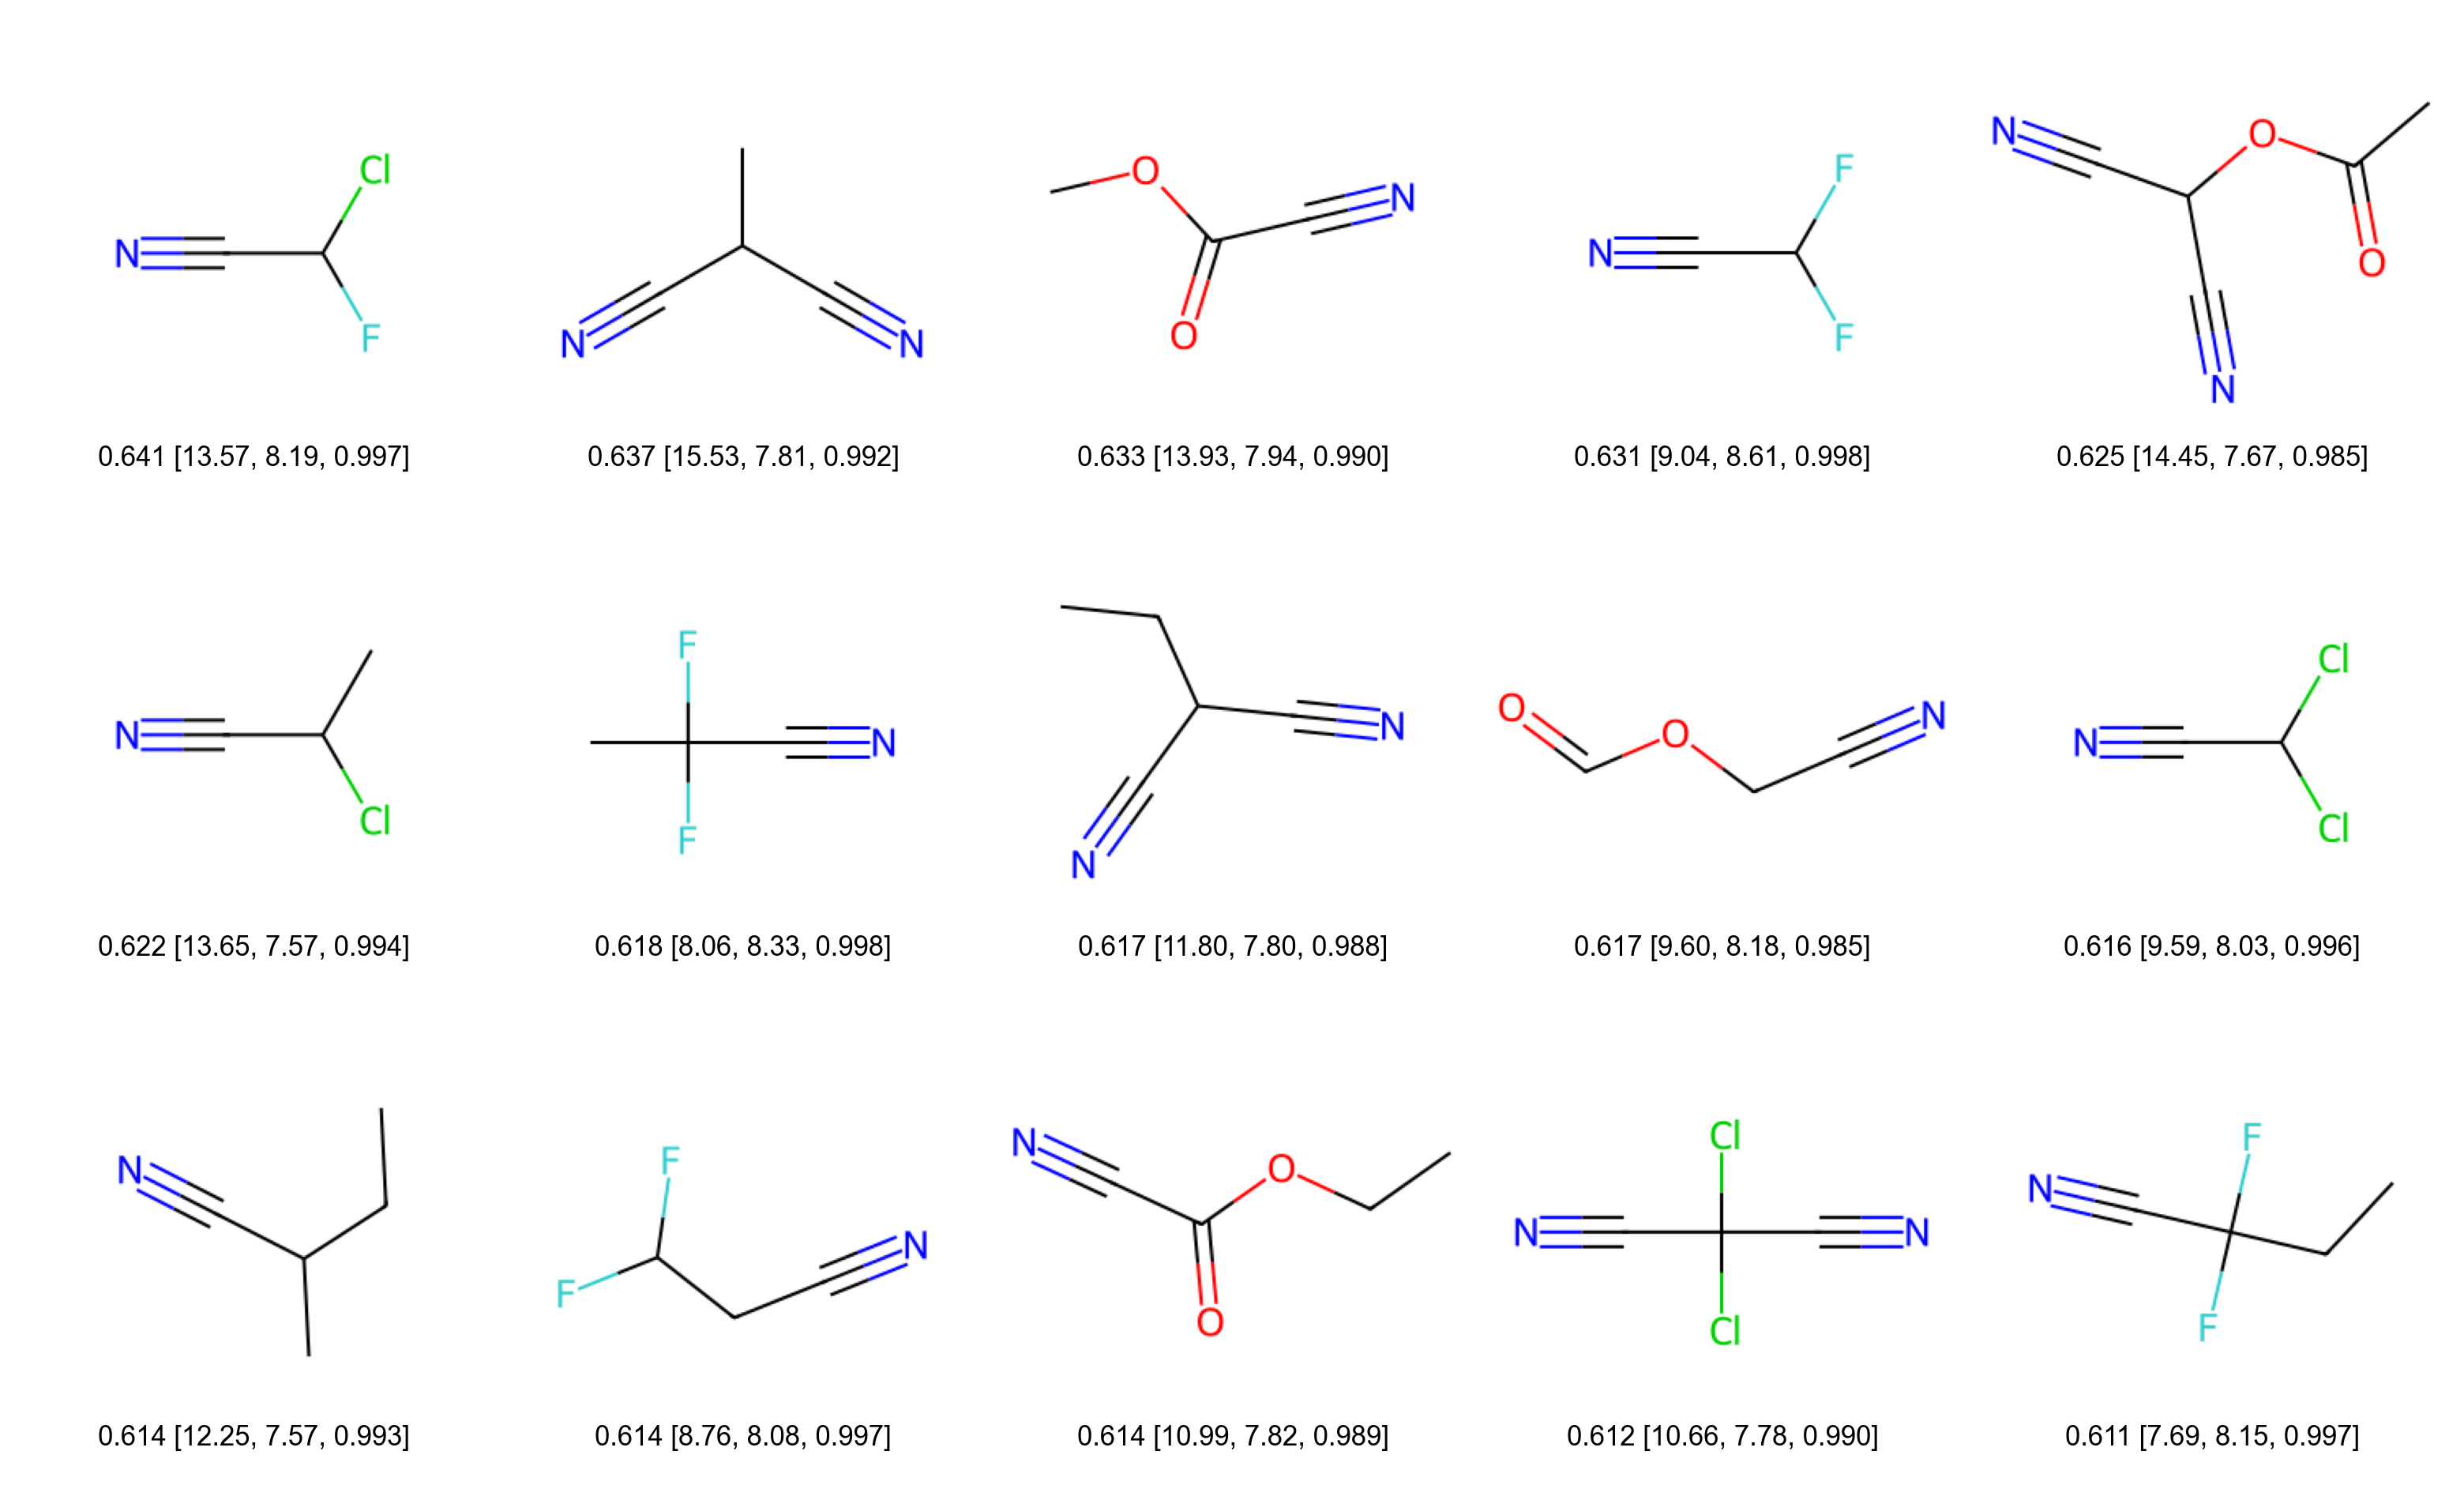

In [65]:
grid_mols_with_annotation(mol_1[:15], label_1[:15], sub_img_size=300, mols_per_row=5, title=None)

In [66]:
label_2 = ['{:.3f} [{:.2f}, {:.2f}, {:.3f}]'.format(high_score_df_2_['overall_score_2'][i], high_score_df_2_['conductivity'][i], high_score_df_2_['oxstab'][i], high_score_df_2_['coulombic_efficiency'][i]) for i in range(len(high_score_df_2_))]
mol_2 = [Chem.MolFromSmiles(smiles) for smiles in high_score_df_2_['solv_comb_sm']]

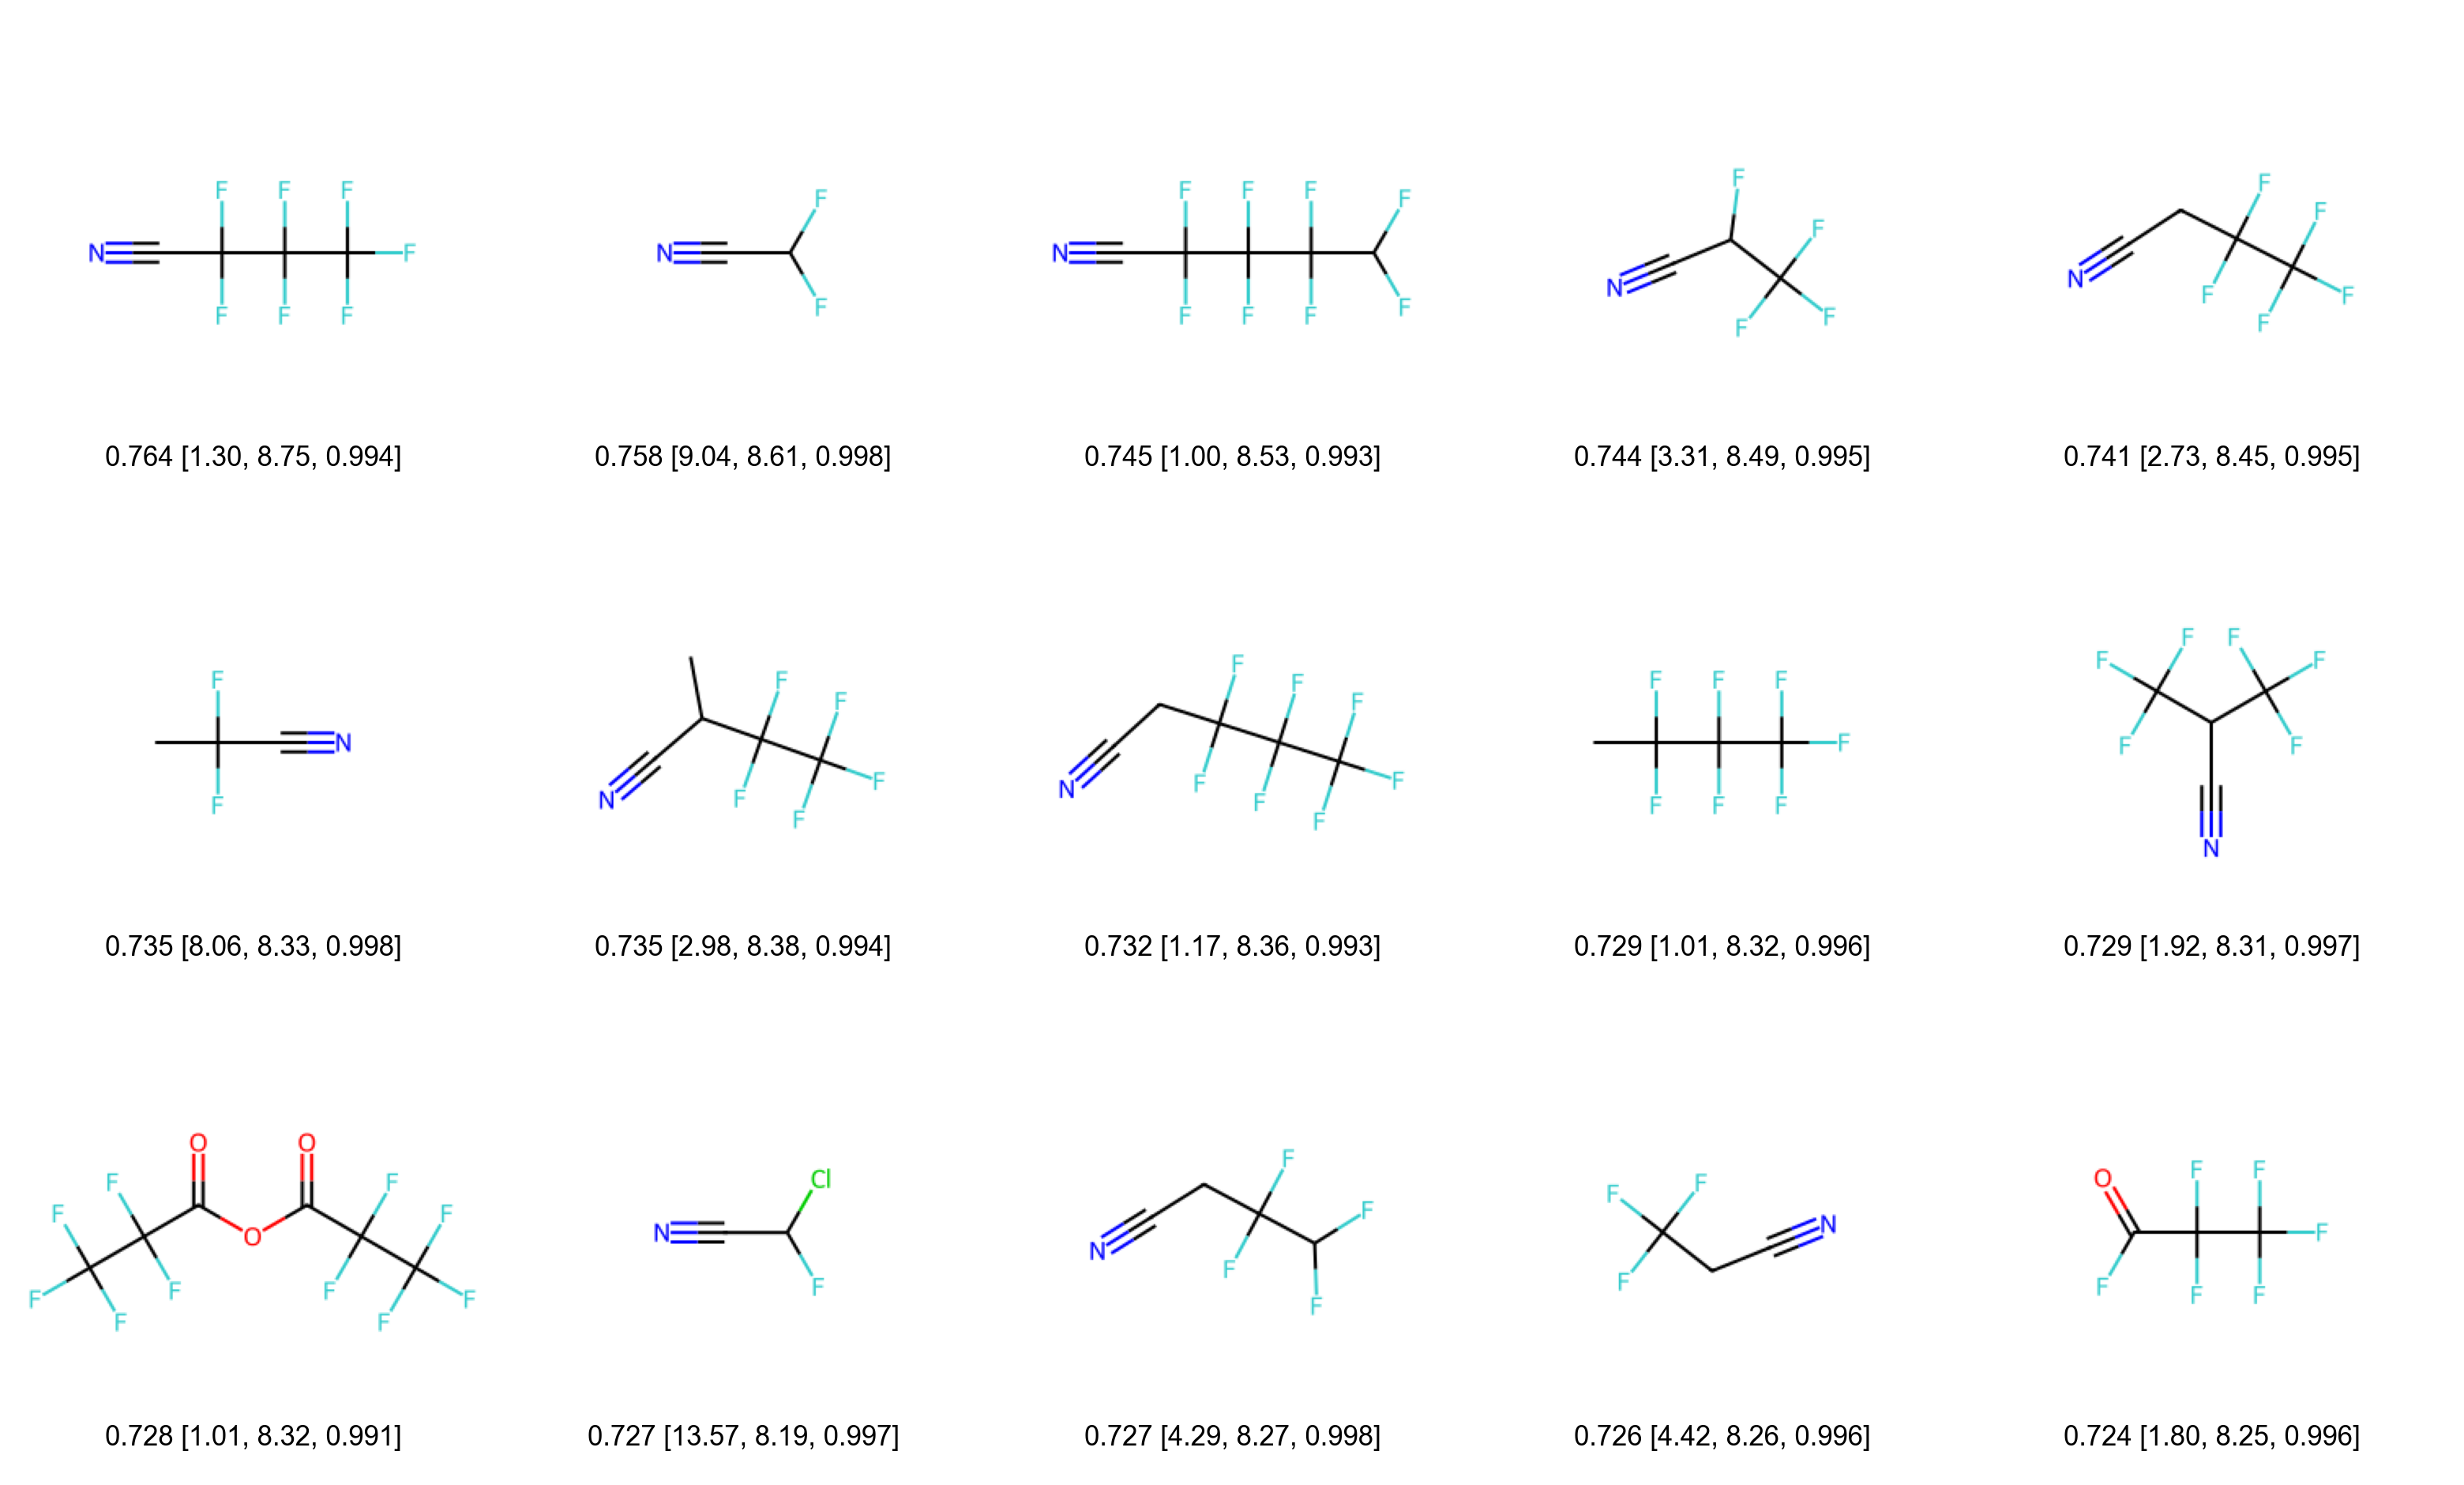

In [67]:
grid_mols_with_annotation(mol_2[:15], label_2[:15], sub_img_size=300, mols_per_row=5, title=None)

In [68]:
label_3 = ['{:.3f} [{:.2f}, {:.2f}, {:.3f}]'.format(high_score_df_3_['overall_score_3'][i], high_score_df_3_['conductivity'][i], high_score_df_3_['oxstab'][i], high_score_df_3_['coulombic_efficiency'][i]) for i in range(len(high_score_df_3_))]
mol_3 = [Chem.MolFromSmiles(smiles) for smiles in high_score_df_3_['solv_comb_sm']]

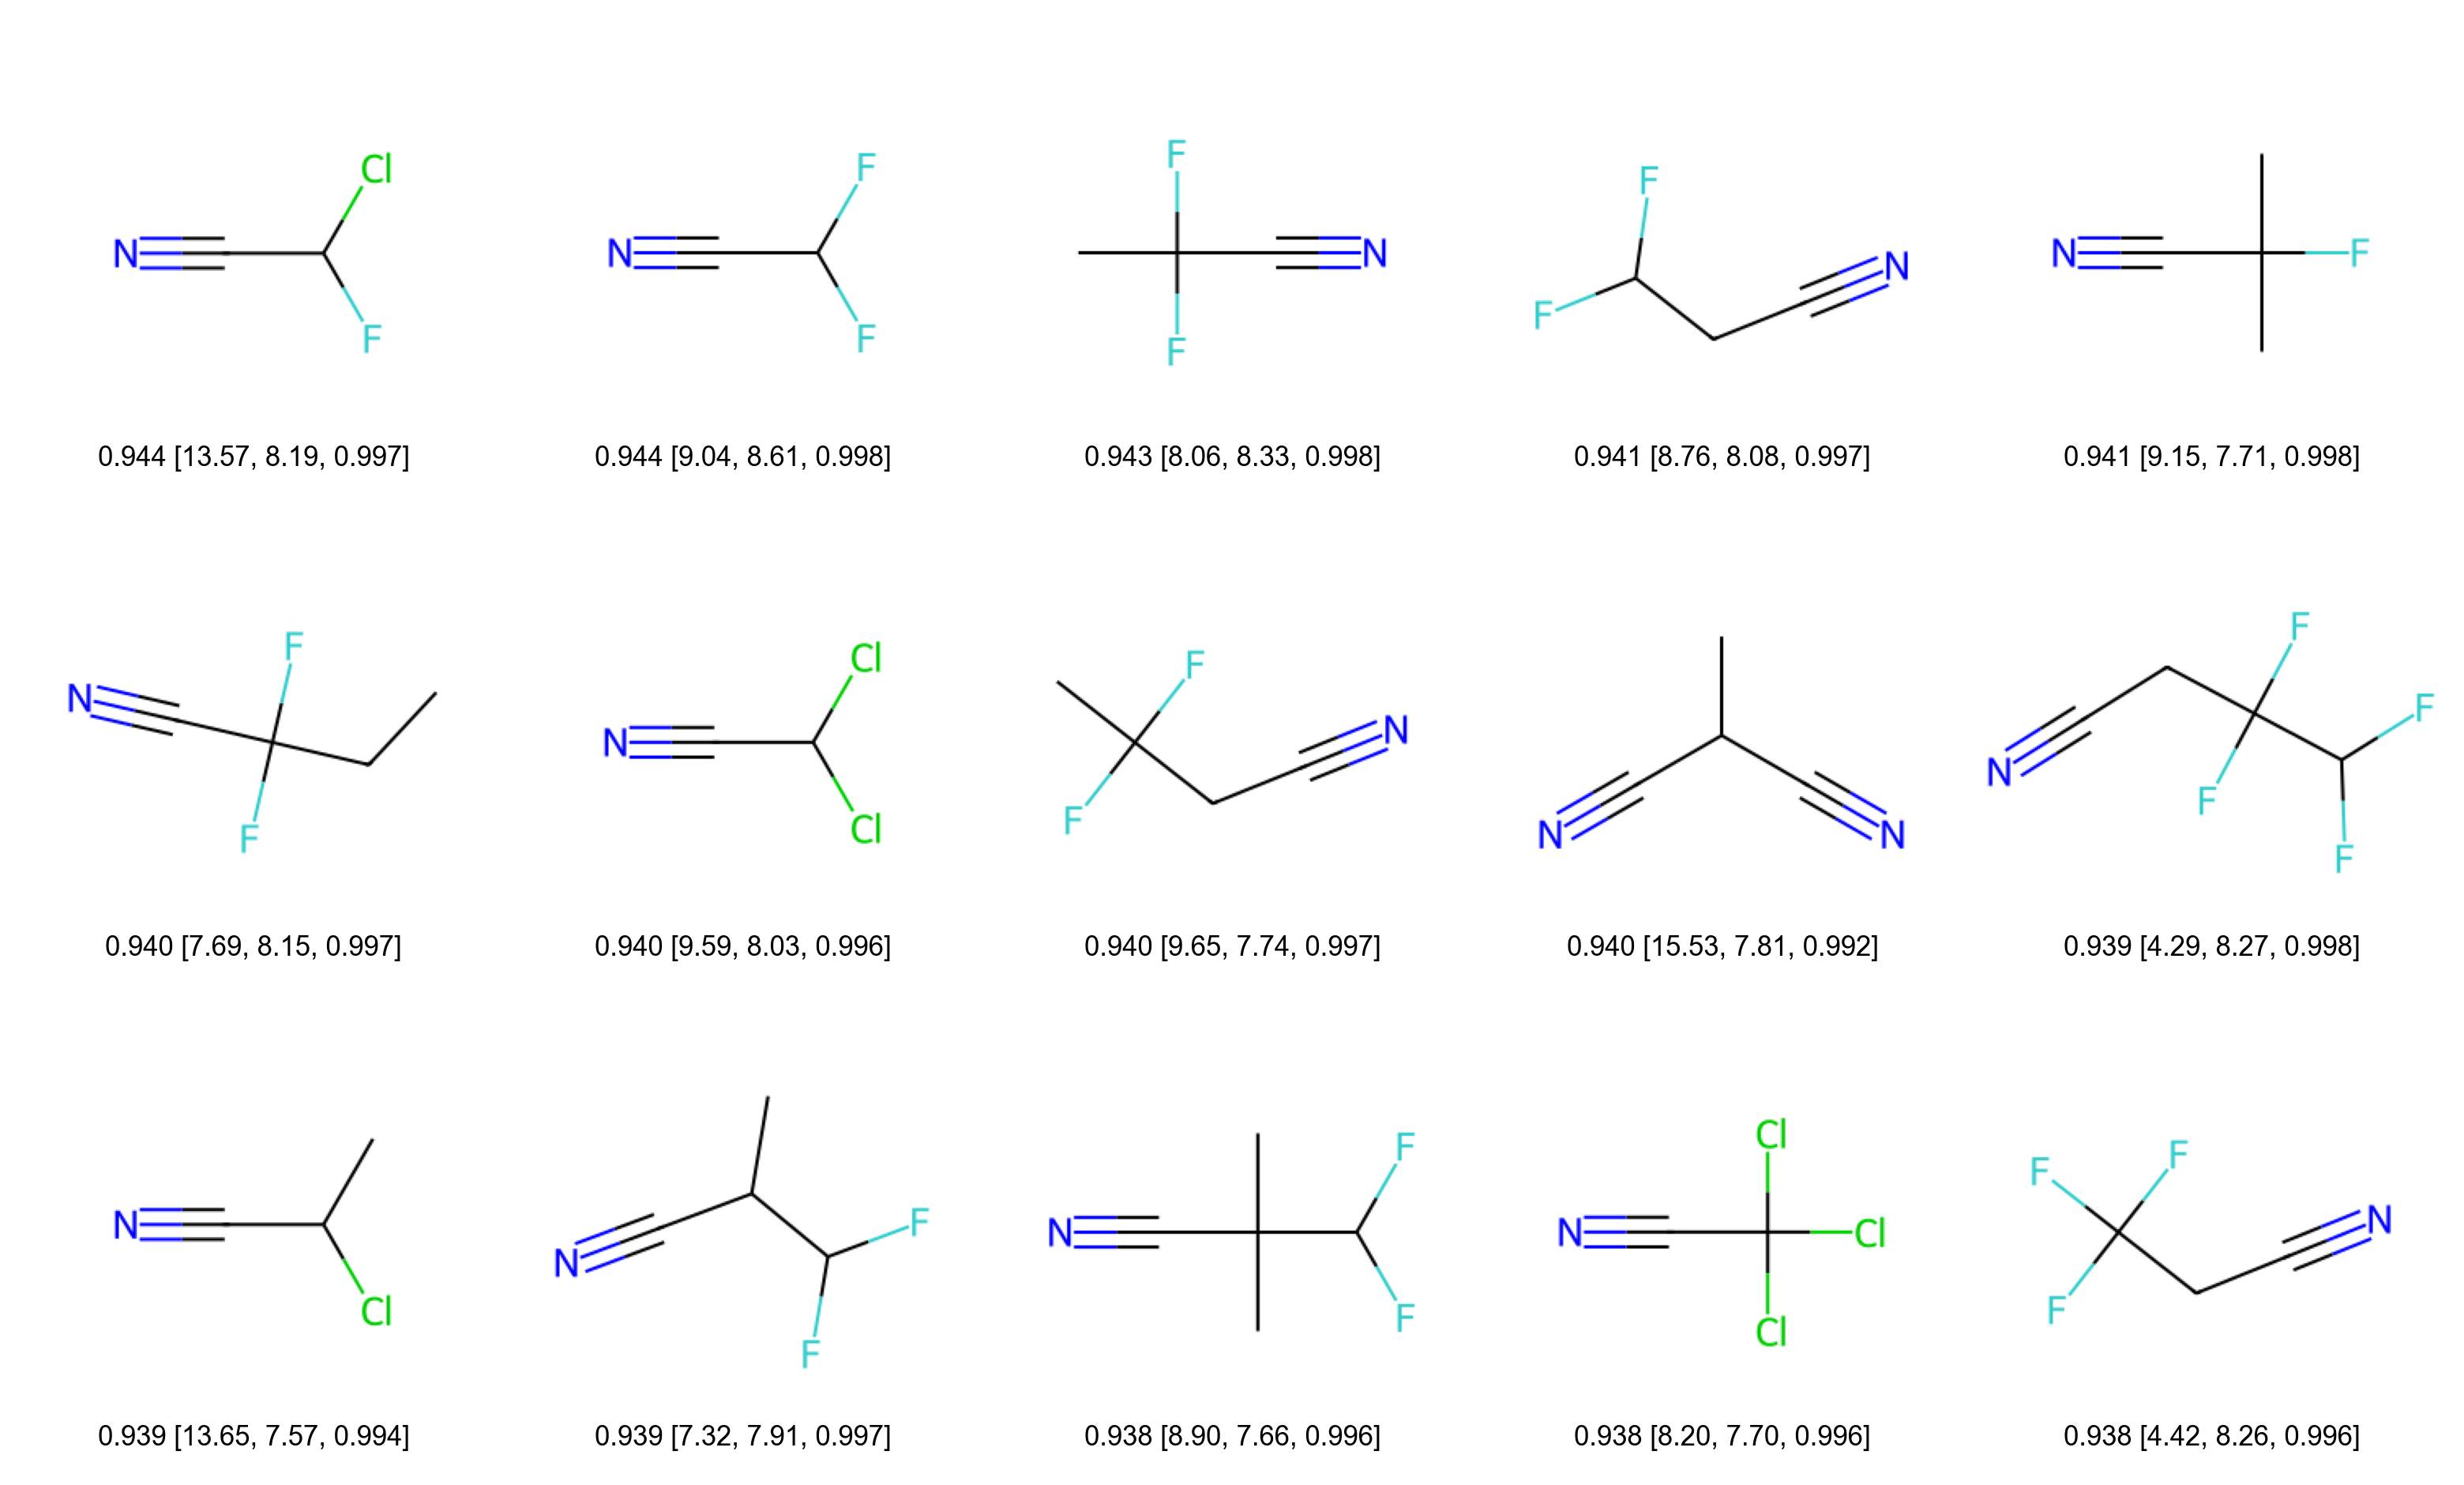

In [69]:
grid_mols_with_annotation(mol_3[:15], label_3[:15], sub_img_size=300, mols_per_row=5, title=None)

In [70]:
label_4 = ['{:.3f} [{:.2f}, {:.2f}, {:.3f}]'.format(high_score_df_4_['overall_score_4'][i], high_score_df_4_['conductivity'][i], high_score_df_4_['oxstab'][i], high_score_df_4_['coulombic_efficiency'][i]) for i in range(len(high_score_df_4_))]
mol_4 = [Chem.MolFromSmiles(smiles) for smiles in high_score_df_4_['solv_comb_sm']]

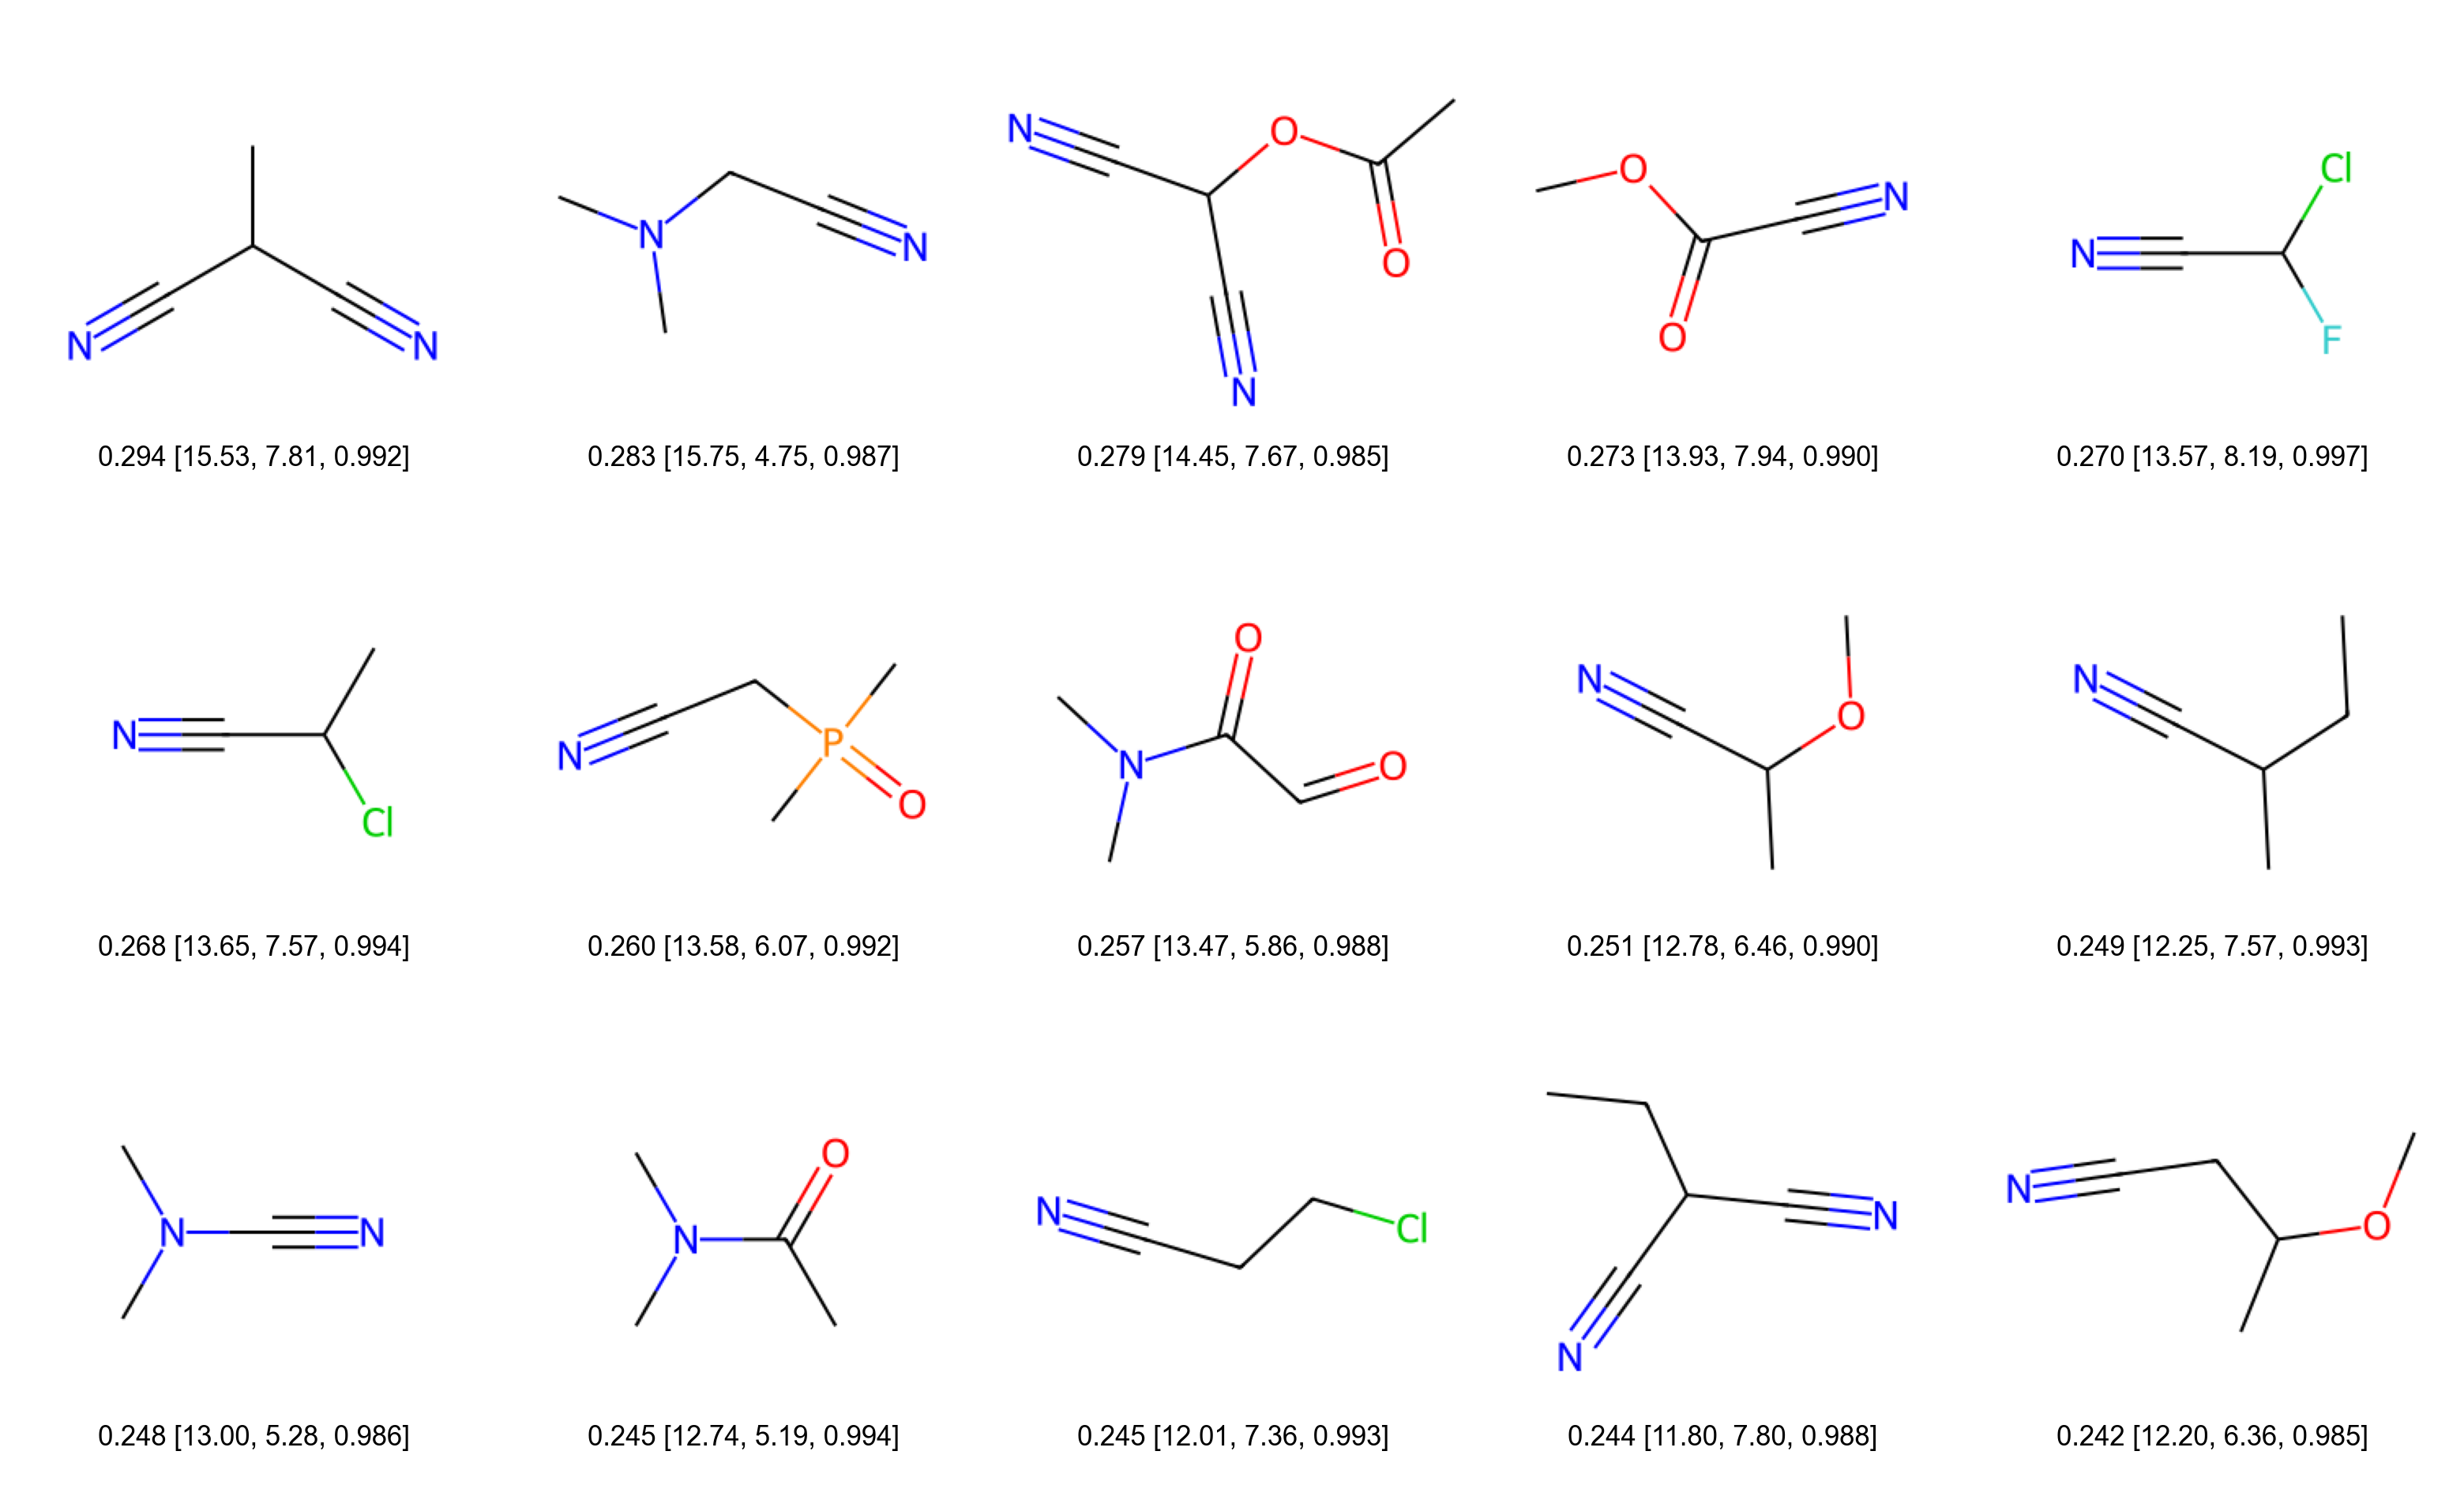

In [71]:
grid_mols_with_annotation(mol_4[:15], label_4[:15], sub_img_size=300, mols_per_row=5, title=None)

In [102]:
df_emol_ce_ = df_emol_ce.sort_values(by='log(1-CE)', ascending=True).iloc[:100]
df_emol_ce_

,solv_comb_sm,salt_sm,log(1-CE)
1828,B12B3B4B5B(B14)[Si]235,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-8.358293
81,B12B3B4B1C234,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-7.374405
7323,N12[Si]34N5[Si]11N3[Si]25N41,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-6.297741
4691,O=C1C(=O)C(=O)C(=O)C(=O)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-3.456071
3400,CC[SiH](Cl)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.798223
...,...,...,...
3581,CN(C)C(=O)C(Cl)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.401466
6289,CC1(CO1)C(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.399943
5706,FC(F)(F)COCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.398368
7110,CC(F)(F)S(F)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.394679


In [105]:
df_emol_ce_[df_emol_ce_['solv_comb_sm'].str.contains('F')]

,solv_comb_sm,salt_sm,log(1-CE)
306,FC(F)(F)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.784631
854,FC(F)(F)C(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.709850
5957,COC(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.704223
20909,FC(F)OCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.700348
60707,FC(F)(F)C(Cl)C(Cl)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.662517
...,...,...,...
36704,FC(F)(F)C(Cl)OC(F)(F)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.402976
6289,CC1(CO1)C(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.399943
5706,FC(F)(F)COCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.398368
7110,CC(F)(F)S(F)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-2.394679


In [108]:
df_emol_cond_ = df_emol.sort_values(by='conductivity_log', ascending=False).iloc[:100]
df_emol_cond_

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var,conductivity,coulombic_efficiency,oxstab
159,COC(=O)C(C)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.313613,0.016883,20.587940,0.938222,7.219003
8,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.211514,0.006134,16.274747,0.964215,5.410431
824,CS(=O)CC#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.203351,0.011057,15.971684,0.978567,6.117861
19,CN(C)CC#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.197383,0.009456,15.753705,0.981681,4.749834
130,COC(=O)CC#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.194653,0.010754,15.654995,0.962609,7.080172
...,...,...,...,...,...,...,...
3581,CN(C)C(=O)C(Cl)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.994509,0.007699,9.874354,0.996032,5.768443
281,N#CC1CCOC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.993291,0.008959,9.846713,0.948601,6.555536
4562,O=C1OCCN1CCC#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.993116,0.008988,9.842747,0.917756,6.350027
2042,CC(C)OC(=O)CC#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.992953,0.007820,9.839055,0.965035,6.875094


In [109]:
df_emol_cond_[df_emol_cond_['solv_comb_sm'].str.contains('F')]

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var,conductivity,coulombic_efficiency,oxstab
287,FC(Cl)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.132646,0.035126,13.572054,0.995276,8.186762
325,CC(CF)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.020487,0.017148,10.483024,0.990355,7.617630
46,COC(=O)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.019442,0.004636,10.457836,0.983154,7.140517
2346,CC(C#N)C(C)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.010117,0.025422,10.235695,0.990962,7.689125


In [110]:
df_emol_os_ = df_emol_os.sort_values(by='IE', ascending=False).iloc[:100]
df_emol_os_

,solv_comb_sm,salt_sm,IE,IE_ensemble_uncal_var
1400,O=C1OCC(O1)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.790047,0.004193
17029,FC(F)(F)C(F)(F)C(F)(F)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.751907,0.056584
44697,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.723934,0.011777
52023,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.659773,0.018742
39261,FC(F)(F)C(F)(F)C(F)(F)C(F)(C(F)(F)F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.655366,0.014299
...,...,...,...,...
51607,FC(F)(F)C1(F)C(F)(F)C(F)(F)C(F)(C(F)(F)F)C(F)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.013250,0.036834
17822,FC(CCC#N)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.011887,0.033898
34060,FC(F)(F)C1(F)C(F)(F)C(F)(F)C1(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.002323,0.025230
18669,CC(C(F)=O)(C(F)(F)F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.000572,0.057420


In [111]:
df_emol_os_[df_emol_os_['solv_comb_sm'].str.contains('F')]

,solv_comb_sm,salt_sm,IE,IE_ensemble_uncal_var
17029,FC(F)(F)C(F)(F)C(F)(F)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.751907,0.056584
44697,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.723934,0.011777
52023,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.659773,0.018742
39261,FC(F)(F)C(F)(F)C(F)(F)C(F)(C(F)(F)F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.655366,0.014299
29135,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.609023,0.048507
...,...,...,...,...
51607,FC(F)(F)C1(F)C(F)(F)C(F)(F)C(F)(C(F)(F)F)C(F)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.013250,0.036834
17822,FC(CCC#N)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.011887,0.033898
34060,FC(F)(F)C1(F)C(F)(F)C(F)(F)C1(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.002323,0.025230
18669,CC(C(F)=O)(C(F)(F)F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,8.000572,0.057420


In [48]:
high_score_df_1_.loc[high_score_df_1_['solv_comb_sm'] == 'CCOCCS(F)(=O)=O']

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol
783,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276,0.549244,<rdkit.Chem.rdchem.Mol object at 0x289135270>


In [49]:
high_score_df_2_.loc[high_score_df_2_['solv_comb_sm'] == 'CCOCCS(F)(=O)=O']

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_2
801,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276,0.610943


In [50]:
high_score_df_3_.loc[high_score_df_3_['solv_comb_sm'] == 'CCOCCS(F)(=O)=O']

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_3
1213,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276,0.923254


In [51]:
high_score_df_4_.loc[high_score_df_4_['solv_comb_sm'] == 'CCOCCS(F)(=O)=O']

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_4
1198,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276,0.130179


In [52]:
high_score_df_1_.loc[high_score_df_1_['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol
226,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497,0.569395,<rdkit.Chem.rdchem.Mol object at 0x289128ac0>


In [53]:
high_score_df_1_.loc[high_score_df_1_['solv_comb_sm'] == 'CCN1CCOCC1'] ## EM

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol


In [54]:
high_score_df_1_.loc[high_score_df_1_['solv_comb_sm'] == 'COC(=O)C#N'] ## MCF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol
2,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211,0.632583,<rdkit.Chem.rdchem.Mol object at 0x17fe0ddd0>


In [72]:
high_score_df_2_.loc[high_score_df_2_['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_2
415,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497,0.639997


In [73]:
high_score_df_3_.loc[high_score_df_3_['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_3
222,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497,0.930745


In [74]:
high_score_df_4_.loc[high_score_df_4_['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_4
420,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497,0.154698


In [75]:
emol_os

array([[7.48839137],
       [6.35543169],
       [6.97395331],
       ...,
       [3.91693425],
       [4.14721864],
       [5.26177091]])